In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils

2023-04-17 22:53:25.664649: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import Runner

2023-04-17 22:53:27.942839: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-17 22:53:28.101680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-17 22:53:28.101751: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-17 22:53:28.105726: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-17 22:53:28.105769: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-17 22:53:28.106812: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [10]:
R = Runner(verbose=True, classifier='kattunet2d')

*** GP2 ***
Working directory: /tmp/tmpb_p8u2x6GP2
Verbose mode active!
Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, 512, 512, 32) 288         input_3[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_bn (BatchNormaliza (None, 512, 512, 32) 128         unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_0_activation (ReLU)  (None, 512, 512, 32) 0           unet_down0_0_bn[0][0]            
_________________

In [11]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [12]:
images.shape

(10000, 512, 512, 1)

In [13]:
masks.shape

(10000, 512, 512, 1)

In [14]:
print(images.max())

255


In [15]:
print(images.min())

0


In [16]:
print(masks.max())

True


In [17]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}
PERCENT_TO_REPLACE = 30

In [18]:
R.setup_data(images, masks, dataset_size=10000, weights=weights)

Weights OK!


In [19]:
RUNS = 5

In [20]:
for run in range(RUNS):
    print('***')
    print('RUN:', run)
    t0 = time.time()
    R.run_classifier()
    R.run_discriminator()
    l = R.find_machine_labels()
    if l == 0:
        print('No more machine labels.')
        print('TOOK', time.time()-t0, 'seconds')
        break
    R.relabel(percent_to_replace=PERCENT_TO_REPLACE)
    print('TOOK', time.time()-t0, 'seconds')
    

***
RUN: 0


2023-04-17 23:09:57.048085: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-17 23:09:57.067012: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz


Epoch 1/100


2023-04-17 23:10:00.361613: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-17 23:10:01.090088: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-17 23:10:01.860891: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-17 23:10:01.860915: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-17 23:10:01.860972: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-17 23:10:01.881506: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-17 23:10:02.802781: I tensorflow/stream_exec

8/8 [==============================] - 91s 7s/step - loss: 0.5349 - dice_coef: 0.1632 - val_loss: 0.6918 - val_dice_coef: 0.0959


2023-04-17 23:11:31.358606: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 0.5351 - dice_coef: 0.1630 - val_loss: 0.6785 - val_dice_coef: 0.1095
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 0.5351 - dice_coef: 0.1631 - val_loss: 0.6695 - val_dice_coef: 0.1164
Model saved to: /tmp/tmpb_p8u2x6GP2/kunet2d_0kunet2d_model
History saved to: /tmp/tmpb_p8u2x6GP2/kunet2d_history_0.pkl
Testing the classifier...
Model saved to /tmp/tmpb_p8u2x6GP2/cnnd_0.model
History saved to /tmp/tmpb_p8u2x6GP2/cnnd_history_0.pickle
Testing the discriminator...
19/19 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Found 294 machine labels.
Machine labels [  0   2   5   6  11  12  13  15  16  17  19  20  21  22  23  24  25  26
  27  28  32  36  39  41  42  44  45  46  47  48  50  51  56  57  58  63
  64  65  67  68  75  77  78  80  81  83  89  92  94  96  98 101 103 104
 105 106 109 110 111 112 115 116 120 124 125 131 134 136 137 139 140 141
 145 146 149

Epoch 1/100
10/10 [==============================] - 26s 3s/step - loss: 0.5345 - dice_coef: 0.1629 - val_loss: 0.6587 - val_dice_coef: 0.1217
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 0.5347 - dice_coef: 0.1619 - val_loss: 0.6486 - val_dice_coef: 0.1251
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 0.5345 - dice_coef: 0.1616 - val_loss: 0.6386 - val_dice_coef: 0.1274
Epoch 4/100
10/10 [==============================] - 12s 1s/step - loss: 0.5346 - dice_coef: 0.1618 - val_loss: 0.6292 - val_dice_coef: 0.1290
Epoch 5/100
10/10 [==============================] - 12s 1s/step - loss: 0.5344 - dice_coef: 0.1614 - val_loss: 0.6203 - val_dice_coef: 0.1302
Epoch 6/100
10/10 [==============================] - 12s 1s/step - loss: 0.5347 - dice_coef: 0.1621 - val_loss: 0.6121 - val_dice_coef: 0.1311
Epoch 7/100
10/10 [==============================] - 12s 1s/step - loss: 0.5343 - dice_coef: 0.1624 - val_loss: 0.6046 - val_dice_coef: 0.1317

Replacing 99 from 298 !
D_relabeled_ 99
selected_ids ['181a48fc-4cb5-477f-9044-6f227b1da7c6', 'd0c3ad0f-b247-4feb-badc-998afed3a5b5', 'dd7d4117-981e-4c0a-a2e9-6aeec319cdb9', 'a74b15e9-3e67-4090-879e-612d78e97d15', 'c5b0eb5a-0bd3-44aa-8aee-8c60fa084343', 'a9c38098-a368-4a60-8917-1d5196ccdd42', '42812a99-ced7-485a-8547-c086535243bf', '9410558f-b92d-4dae-996d-02aecf4768d5', '2e1abc46-577a-4add-8465-ec3526b6ae04', 'f91358ae-05cc-4622-a858-b2fd6f7402d6', '09dc3e53-071d-45ef-9150-152c50b54ecf', '76b76fea-e99a-4f13-ac22-34e423a0b36d', '75293d04-8638-4cdd-b78b-f2089a2ae5ec', '7e2f580c-ab61-40a6-a5de-360ba42527fa', '96e55446-374d-45b1-85f4-39eb4e8723be', 'dbe6e74f-ccc5-4ce8-9979-c746e412c400', '63ec1221-53cf-4000-a1e2-b8df9bd70901', '11bec389-74d6-4169-8b9d-19cff6a8c6e2', '8684795b-e183-47b0-80ae-e4179b8428e9', '7252fb08-fd05-4e8c-bf90-4b2ddc8d0cfe', '7d78afcb-1ed9-47c2-9cf5-e5a2dc3b1806', 'aeb05575-2891-45d4-beaa-13d032d85a9f', '339636ee-4af8-4951-afda-9f1a8eeb5eda', '8af53b13-c539-4d5f-b4a3-2

Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.5349 - dice_coef: 0.1618 - val_loss: 0.5789 - val_dice_coef: 0.1328
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.5350 - dice_coef: 0.1617 - val_loss: 0.5735 - val_dice_coef: 0.1330
Epoch 4/100
11/11 [==============================] - 13s 1s/step - loss: 0.5354 - dice_coef: 0.1615 - val_loss: 0.5686 - val_dice_coef: 0.1332
Model saved to: /tmp/tmpb_p8u2x6GP2/kunet2d_2kunet2d_model
History saved to: /tmp/tmpb_p8u2x6GP2/kunet2d_history_2.pkl
Testing the classifier...
Testing the discriminator...
19/19 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Found 313 machine labels.
Machine labels [  1   2   3   4   5   7   9  11  14  15  18  21  22  25  30  31  32  33
  35  39  40  41  42  45  48  49  51  54  55  56  57  60  61  65  66  68
  71  72  73  74  75  80  83  84  85  86  87  92  98 100 101 106 107 111
 112 113 115 116 117 118 119 120 122 123 124 

Replacing 104 from 313 !
D_relabeled_ 104
selected_ids ['5801e516-bd08-49a3-8b13-e7b6dcadeef1', 'fc5cfffa-1b05-4aaf-b882-f9271c919a19', '47180259-6ee3-4721-86e6-58d7093017ae', '8076aef3-c0ca-4e3c-9b27-f6acc5b907d6', 'cf8055b1-801d-462d-9439-708a14cefb08', 'ba370900-e2bd-4ecf-8018-0090468f57ca', '90657745-207d-4d61-8ddc-a27ad97c92b0', '1d9eb10d-01de-45bd-8e9c-74dcf0a5e720', 'b899ac7f-984c-463b-b884-90cf81d740a5', 'dcb775a3-2f84-467d-9c80-53811068bad4', '6d32670c-3149-44c0-83cb-22b566001ff0', '454b3c67-d006-4016-938f-8fdc05b2af28', '1b3de295-a5e3-42ef-8efd-7ffd8a689fca', '71e464eb-015e-42fc-b811-7cf83654b980', 'f0ee265d-fce6-4bca-81b0-b196ca212a95', '545dd376-ec4e-4dbb-866a-0cd97b43e53d', 'cfe5cdb7-71b5-44d7-a93d-be4dc7d8a9f0', 'f197d0a3-7dd9-4b08-9794-1feebe626f9b', '7e0f3259-a0a0-4ace-8eb8-95c321ab45dd', '609c38e7-a7cb-4e9d-ae69-f1e355adecae', 'c15be09c-4180-4e67-8b98-e4b4da39128c', '7c98d2a8-2cdf-4083-8b85-53c0193d282f', '974b8663-cdb7-4679-b6da-84b70d8c5b9e', '89b1d27d-ac92-4fff-91a4

Removed: 104 Filled: 104
TOOK 199.24416065216064 seconds
***
RUN: 3
Epoch 1/100
13/13 [==============================] - 36s 3s/step - loss: 0.5349 - dice_coef: 0.1618 - val_loss: 0.5632 - val_dice_coef: 0.1334
Epoch 2/100
13/13 [==============================] - 15s 1s/step - loss: 0.5348 - dice_coef: 0.1616 - val_loss: 0.5584 - val_dice_coef: 0.1337
Epoch 3/100
13/13 [==============================] - 15s 1s/step - loss: 0.5350 - dice_coef: 0.1614 - val_loss: 0.5541 - val_dice_coef: 0.1341
Epoch 4/100
13/13 [==============================] - 15s 1s/step - loss: 0.5348 - dice_coef: 0.1617 - val_loss: 0.5502 - val_dice_coef: 0.1345
Epoch 5/100
13/13 [==============================] - 15s 1s/step - loss: 0.5349 - dice_coef: 0.1613 - val_loss: 0.5468 - val_dice_coef: 0.1350
Epoch 6/100
13/13 [==============================] - 15s 1s/step - loss: 0.5348 - dice_coef: 0.1618 - val_loss: 0.5436 - val_dice_coef: 0.1356
Epoch 7/100
13/13 [==============================] - 15s 1s/step - loss: 0

Replacing 99 from 299 !
D_relabeled_ 99
selected_ids ['b4e2ed9d-49d6-4224-8f0a-436b8cea380e', '85cac409-9d1c-42f4-a9b6-f781b5bfe6c0', '9ff481b1-76f5-433f-8f0e-513a2ea74f48', 'c63880cc-15b4-440a-9e13-fad9d56fdb28', '35728049-13f6-4e9b-b77c-1bb33f2be331', '666df35b-6253-4cd5-a369-df2ca4effc52', '036a7df4-5124-4517-9249-c19bc9535312', 'a31e5c9f-90b4-41bb-ac84-928752a8b809', '787f3ce1-7c3f-42f6-a0a9-d1cd7f624ad8', '4c2fcb7d-cd54-4eae-80da-eb6734515a1e', '220c5326-bfdf-4163-bd91-d770c04a0e7c', '8758a50d-5b02-4eec-b846-c48b48d1d488', '2dfcda3d-06d2-44c8-a25b-6858584265d2', '06b7da2e-5677-40cc-aeb9-8f8a74a81f89', '3aaa1bfb-5e03-4a19-824f-f301da866e61', '9565f9fb-9920-4835-a3a4-9037039c2719', '479dcd4a-9c26-4b16-9332-cdede12cf991', 'd54d2b89-44a0-4b5c-9517-79489704eb1b', 'bd455a07-243b-4d63-84c8-5434b1455083', '757a004c-729c-46a0-b440-b285084fd5b7', 'd2b6f66b-06e5-4301-bf0d-5dc261a5d629', '14aaa09c-1bb4-47ef-915f-34c2f03cb2c2', '4eed8049-2c7f-48c4-a014-644e5898c262', 'd448d7d5-bd2e-4669-93ff-a

Epoch 2/100
15/15 [==============================] - 16s 1s/step - loss: 0.5356 - dice_coef: 0.1618 - val_loss: 0.5343 - val_dice_coef: 0.1392
Epoch 3/100
15/15 [==============================] - 16s 1s/step - loss: 0.5356 - dice_coef: 0.1620 - val_loss: 0.5326 - val_dice_coef: 0.1405
Epoch 4/100
15/15 [==============================] - 16s 1s/step - loss: 0.5356 - dice_coef: 0.1615 - val_loss: 0.5312 - val_dice_coef: 0.1418
Epoch 5/100
15/15 [==============================] - 16s 1s/step - loss: 0.5355 - dice_coef: 0.1638 - val_loss: 0.5297 - val_dice_coef: 0.1433
Epoch 6/100
15/15 [==============================] - 16s 1s/step - loss: 0.5355 - dice_coef: 0.1602 - val_loss: 0.5292 - val_dice_coef: 0.1446
Epoch 7/100
15/15 [==============================] - 16s 1s/step - loss: 0.5357 - dice_coef: 0.1623 - val_loss: 0.5287 - val_dice_coef: 0.1460
Epoch 8/100
15/15 [==============================] - 16s 1s/step - loss: 0.5354 - dice_coef: 0.1633 - val_loss: 0.5283 - val_dice_coef: 0.1475

Replacing 101 from 305 !
D_relabeled_ 101
selected_ids ['f101076b-3c72-46bf-96ff-57c4359dd25e', '566ac2bb-e264-4833-a193-7cbbb5a39239', '8c0eb651-434d-41aa-9349-7afdc242a43a', 'b49860de-747a-468b-b60a-e180e36fb3f2', '6c3ec92e-5300-4a6f-98be-1bb44c02d772', '8061ec05-72d9-40c4-8e4f-41d470424ef3', '05f00d64-1aa4-4e83-ba50-5af0410ba7cc', 'b721229d-e8a7-4dd2-a0e1-101784fc8618', 'c8bd1f5d-e5e0-4c7b-b534-bad1d54e7aea', '2b4ac1c5-c40c-47cc-aee0-bfae469990ac', '26bf1c31-fdfe-4b5f-9174-a8a2ad21a3df', '2fd851fb-7bd2-4e85-a68b-f8110ffb2c13', '6a9a9836-a1e7-4618-bbb7-f45385b54131', '6465402d-28fb-4d1c-8e94-1bff4e52ddf7', '280ee259-35f5-4a2d-8556-2ab162d07c71', '85714bc6-2693-4690-8af4-5a65650bd459', '8f1baa49-57a1-47f7-98ac-eb80fbcedd0b', '1e6411fd-490c-4190-895e-4baec1b13dee', 'b8432ba4-6e92-45f2-b886-b430a51dfd85', '1f3c990d-3e36-411e-9c30-6c2e66b4188c', 'fb693097-a021-4f9c-b014-011f51908be6', '94c4b715-088d-4047-8d32-88b0da2b3106', '7fa54f72-724a-46d5-bab8-94583e84efc7', '88ba71e8-6790-45ab-a62a

In [15]:
R.classifier_scores

[344.25732421875,
 348.4939880371094,
 346.9913330078125,
 347.586669921875,
 347.3193359375]

In [16]:
R.discriminator_scores

[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]

In [17]:
R.plot()

TypeError: 'float' object is not subscriptable

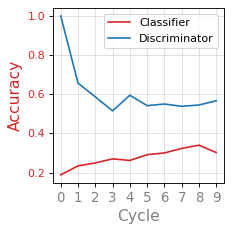

In [18]:
R.plot()

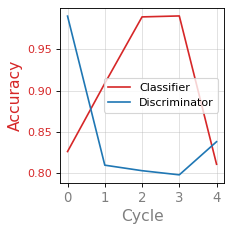

In [17]:
R.plot()